# Spectral Biclustering

Ref: Kluger, Yuval, et. al., 2003. Spectral biclustering of microarray data: coclustering genes and conditions.
* [blog](http://www.kemaleren.com/post/spectral-biclustering-part-1/)

In [1]:
import numpy as np
import pandas as pd
import altair as alt

import concensus_clustering

from copy import deepcopy

from sklearn.cluster.bicluster import SpectralCoclustering

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

sns.set()
%matplotlib inline

In [2]:
feature_categories = [
    'shape',
    'firstorder',
    'glcm',
    'glrlm',
    'glszm',
    'gldm',
    'ngtdm',
    'PETparam', 
    'clinical'
]

In [3]:
def category_counts(_):
    
    return {
        'shape': 0,
        'firstorder': 0,
        'glcm': 0,
        'glrlm': 0,
        'glszm': 0,
        'gldm': 0,
        'ngtdm': 0,
        'PETparam': 0,
        'clinical': 0,
    }

In [4]:
def _update_count(pet_output, ct_output, key):

    if 'PET' in key:
        pet_output[key] += 1
    else:
        ct_output[key] += 1
            
    return pet_output, ct_output

In [5]:
def _norm_count(pet_output, ct_output, key, tot_counts):
    
    if 'PET' in key:
        pet_output[key] /= tot_counts[key]
    else:
        ct_output[key] /= tot_counts[key]
            
    return pet_output, ct_output

In [127]:
def to_feature_categories(cluster_indices, X):
    
    pet_output = category_counts(None)
    ct_output = category_counts(None)
    
    
    for label in X.columns[cluster_indices]:
        if 'shape' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'shape')
        elif 'firstorder' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'firstorder')
        elif 'glcm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glcm')
        elif 'glrlm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glrlm')
        elif 'glszm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glszm')
        elif 'gldm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'gldm')
        elif 'ngtdm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'ngtdm')
        elif 'PETparam' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'PETparam')
        else:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'clinical')
        
    feature_counts = {
        'shape': 14,
        'firstorder': 46,
        'glcm': 132,
        'glrlm': 84,
        'glszm': 84,
        'gldm': 78,
        'ngtdm': 30,
        'PETparam': 3, 
        'clinical': 42
    }
    for label in feature_counts.keys():
        pet_output, ct_output = _norm_count(pet_output, ct_output, label, feature_counts)

    return pet_output, ct_output

In [7]:
def biclusters(model, X, param_config):
    # Create Bicluster instances tracking detected clusters.
    
    # Start fresh with each clustering.
    _model = deepcopy(model)
    
    # Set number of clusters to detect and fit model to data.
    _model.set_params(**param_config)
    _model.fit(X)

    rows, cols = _model.rows_, _model.columns_
    # Sanity check.
    assert np.shape(rows)[0] == np.shape(cols)[0]
    
    biclusters = concensus_clustering.Biclusters(
        rows=rows, cols=cols, data=X
    )
    return biclusters

In [8]:
def checker_coords(model, num_clusters):
    # Collect coordinates for biclusters with a checkerborad structure.
    
    tot_num_clusters = num_clusters[0] * num_clusters[1]
    coords = pd.DataFrame(
        np.zeros((tot_num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    num, prev_rows = 0, 0
    for row_num in range(num_clusters[0]):
        nrows = np.sum(model.rows_[row_num])

        prev_cols = 0
        for col_num in range(num_clusters[1]):
            ncols = np.sum(model.columns_[col_num])

            coords.iloc[num, 0] = prev_rows 
            coords.iloc[num, 1] = prev_rows + nrows
            coords.iloc[num, 2] = prev_cols 
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows

    return coords

In [9]:
def bic_coords(model, num_clusters):
    # Collect coordinates for block diagonal biclusters.

    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    prev_rows, prev_cols = 0, 0
    for num, row_bic in enumerate(model.rows_):
        num_rows = np.sum(row_bic)
        num_cols = np.sum(model.columns_[num])

        coords.iloc[num, 0] = prev_rows
        coords.iloc[num, 1] = prev_rows + num_rows
        coords.iloc[num, 2] = prev_cols
        coords.iloc[num, 3] = prev_cols + num_cols

        prev_rows += num_rows
        prev_cols += num_cols

    return coords

In [10]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        if 'shape' in label:
            prep_labels.append('Shape')
        elif 'PETparam' in label:
            prep_labels.append('PET Parameter')
        elif 'clinical' in label:
            prep_labels.append('Clinical')
        elif 'firstorder' in label:
            prep_labels.append('First Order')
        elif 'glcm' in label:
            prep_labels.append('GLCM')
        elif 'gldm' in label:
            prep_labels.append('GLDM')
        elif 'glrlm' in label:
            prep_labels.append('GLRLM')
        elif 'glszm' in label:
            prep_labels.append('GLSZM')
        elif 'ngtdm' in label:
            prep_labels.append('NGTDM')
        else:
            raise ValueError(f'Unknown label {label}')
    return prep_labels

In [11]:
np.random.seed(seed=0)
random_states = np.random.choice(40, size=40)

In [175]:
co_grid = ParameterGrid({'n_clusters': np.arange(2, 10, 1), 'n_init': [20]})

In [176]:
_y = pd.read_csv('./../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0)
y_orig = np.squeeze(_y.values)

X_orig = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv', index_col=0)

scaler = StandardScaler()
X_orig_std = scaler.fit_transform(X_orig.values)
X_orig_std.shape

(198, 513)

# Spectral Co-Clustering

In [177]:
avg_co_scores = {}
for num, co_param_config in enumerate(co_grid):
    orig_co_scores = []
    for random_state in random_states:
        orig_co_model = SpectralCoclustering(random_state=random_state, svd_method='arpack')
        # NOTE: Outputs a TVE score.
        orig_co_clusters = biclusters(orig_co_model, X_orig_std, co_param_config)
        orig_co_scores.append(orig_co_clusters.external_metrics.values)
    avg_co_scores[num] = np.nanmean(orig_co_scores, axis=0)

In [178]:
avg_orig_co_scores = []
for num, scores in enumerate(avg_co_scores.values()):
    avg_orig_co_scores.append(np.mean(scores, axis=0))
    
df_avg_co_scores = pd.DataFrame(avg_orig_co_scores, columns=['tvr'])
df_avg_co_scores.index.name = 'ConfigID'
df_avg_co_scores.head()

,tvr
ConfigID,
0,1.069693
1,1.069396
2,1.069132
3,1.086354
4,1.086057


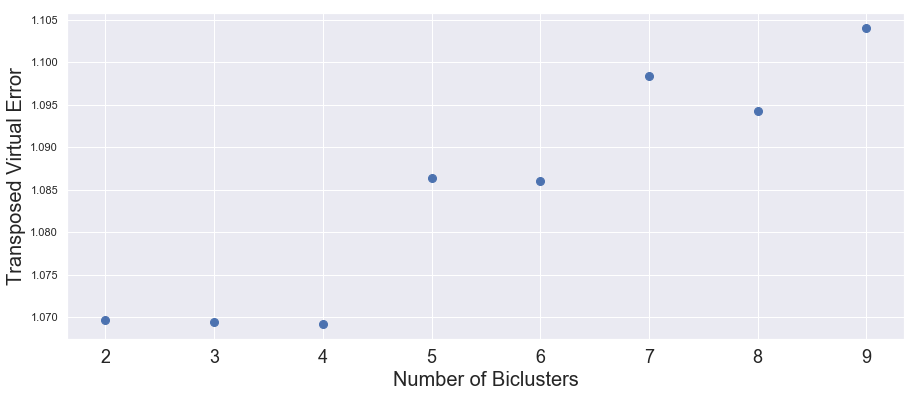

In [206]:
plt.figure(figsize=(15, 6))
x_coords = df_avg_co_scores.loc[:, 'tvr'].index
plt.plot(x_coords, df_avg_co_scores.loc[:, 'tvr'], 'bo', markersize=8)
plt.xticks(np.arange(len(co_grid)), np.arange(2, 10, 1), fontsize=18)
plt.ylabel('Transposed Virtual Error', fontsize=20)
plt.xlabel('Number of Biclusters', fontsize=20)
plt.savefig(
    './../../figures/biclustering/tve_by_param_config.png',
    bbox_inches='tight',
    dpi=100, 
)

In [187]:
best_co_config = co_grid[np.argmin(df_avg_co_scores.loc[:, 'tvr'].values)]
best_co_config, min(df_avg_co_scores.loc[:, 'tvr'].values)

({'n_init': 20, 'n_clusters': 4}, 1.0691315701350526)

## Bicluster Map

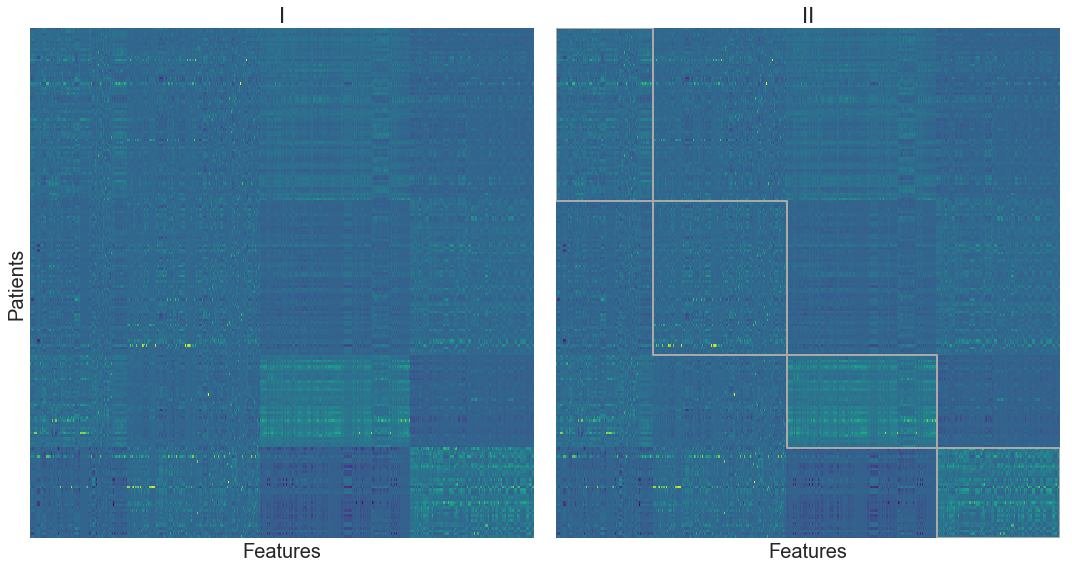

In [188]:
# Train model with best config.
orig_co_model = SpectralCoclustering(random_state=0, svd_method='arpack')
orig_co_model.set_params(**best_co_config)
orig_co_model.fit(X_orig_std)
orig_co_row_sorted = X_orig_std[np.argsort(orig_co_model.row_labels_), :]
orig_co_fit_data = orig_co_row_sorted[:, np.argsort(orig_co_model.column_labels_)]


fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 8),
    sharey=True
)
sns.heatmap(
    orig_co_fit_data, 
    ax=axes[0], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(orig_co_fit_data), 
    vmax=np.max(orig_co_fit_data),
    cbar=False
)
sns.heatmap(
    orig_co_fit_data, 
    ax=axes[1], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(orig_co_fit_data), 
    vmax=np.max(orig_co_fit_data),
    cbar=False
)
#coords = checker_coords(orig_bic_model, best_orig_config['n_clusters'])
coords = bic_coords(orig_co_model, best_co_config['n_clusters'])
for num in coords.index:
    axes[1].plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='darkgray'#'orangered' #darkred
)
axes[0].set_ylabel('Patients', fontsize=20)
titles = ['I', 'II']
for num, axis in enumerate(axes.ravel()):
    axis.set_xlabel('Features', fontsize=20)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(titles[num], fontsize=22)
    
plt.tight_layout()

plt.savefig(
    './../../figures/biclustering/bic_map_original_images.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [189]:
# Collect row cluster info.
orig_row_idx = []
orig_pfs_outcome, orig_not_pfs_outcome = [], []
for bic_row_idx in np.unique(orig_co_model.row_labels_):
    # Store cluster index and ID samples belonging to current cluster.
    orig_row_idx.append(bic_row_idx)
    row_cluster_samples = np.where(orig_co_model.row_labels_ == bic_row_idx)

    # Store fractions of each outcome for current cluster.
    orig_pfs_outcome.append(sum(y_orig[row_cluster_samples] == 0) / np.size(y_orig))
    orig_not_pfs_outcome.append(sum(y_orig[row_cluster_samples] == 1) / np.size(y_orig))
    
orig_sorted_cluster_idx = np.concatenate((orig_row_idx, orig_row_idx))
orig_comb_results = np.concatenate((orig_pfs_outcome, orig_not_pfs_outcome))

orig_results_id =  np.concatenate((
    ['Progression-Free Survival'] * len(orig_pfs_outcome), ['Other Event'] * len(orig_not_pfs_outcome)
))
df_orig_row_clusters = pd.DataFrame(
    {'comb_results': orig_comb_results, 'results_id': orig_results_id},
    index=orig_sorted_cluster_idx,
)

# Collect column cluster info.
orig_column_clusters = {}


for co_col_idx in np.unique(orig_co_model.column_labels_):
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(orig_co_model.column_labels_ == co_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples, X_orig)
    orig_column_clusters[co_col_idx] = {
        key: val_a + val_b for (key, val_a), (_, val_b) in zip(pet_output.items(), ct_output.items())
    }
df_orig_column_clusters = pd.DataFrame(orig_column_clusters).T

In [190]:
df_orig_column_clusters

,PETparam,clinical,firstorder,glcm,gldm,glrlm,glszm,ngtdm,shape
0,0.333333,0.238095,0.347826,0.159091,0.115385,0.083333,0.214286,0.2,0.785714
1,0.000000,0.761905,0.152174,0.174242,0.243590,0.178571,0.392857,0.2,0.071429
2,0.666667,0.000000,0.304348,0.409091,0.307692,0.369048,0.250000,0.2,0.071429
3,0.000000,0.000000,0.195652,0.257576,0.333333,0.369048,0.142857,0.4,0.071429


In [191]:
df_orig_column_clusters.sum()

PETparam      1.0
clinical      1.0
firstorder    1.0
glcm          1.0
gldm          1.0
glrlm         1.0
glszm         1.0
ngtdm         1.0
shape         1.0
dtype: float64

In [192]:
# Observations:
# * The NGTDM feature equally spread across each cluster.
# * The majority of shape features are located in the first cluster.
# * PET-parameters are divided by 1/3 in the second and 2/3 third cluster.
# * The majority (76%) of the clinical variables are located in the secon cluster.

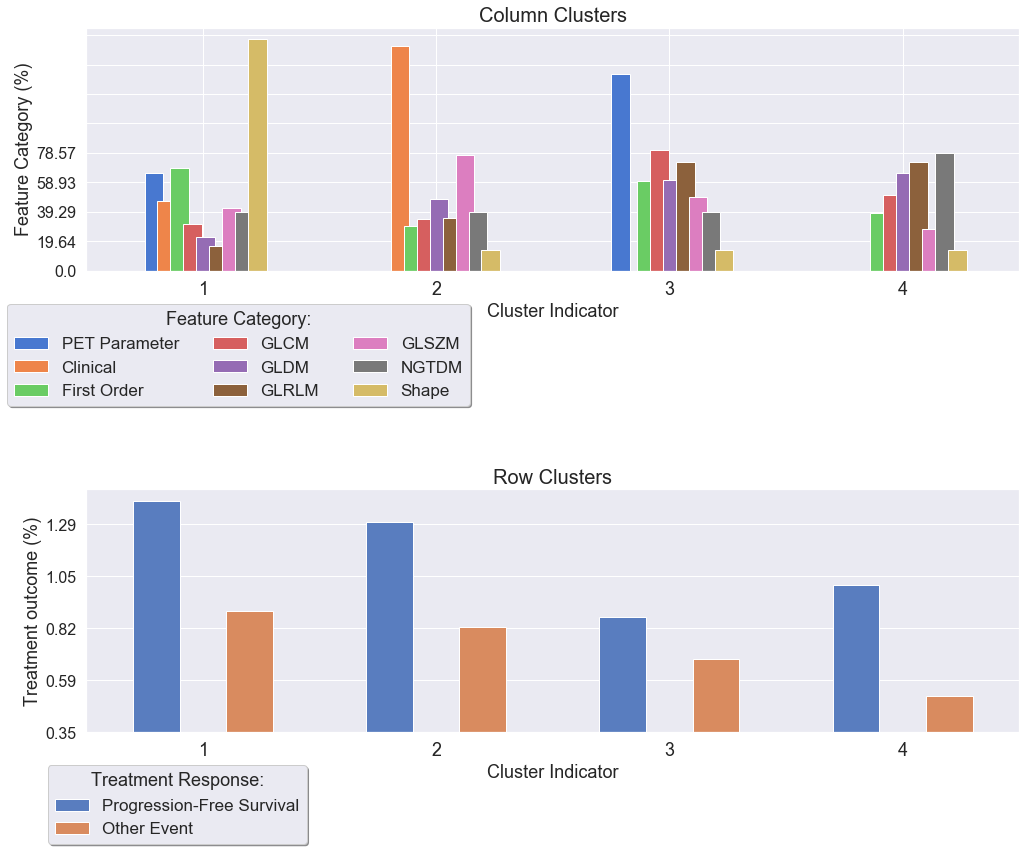

In [193]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 12))
df_orig_column_clusters.plot(
    kind='bar', 
    ax=axes[0], 
    colormap=ListedColormap(sns.color_palette('muted', n_colors=len(df_orig_column_clusters.columns)))
)
sns.barplot(
    x=orig_sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_orig_row_clusters,
    palette='muted',
    ax=axes[1]
)
axes[0].set_xticklabels(np.arange(20) + 1, fontsize=18, rotation=0)
axes[1].set_xticklabels(np.arange(20) + 1, fontsize=18, rotation=0)

axes[0].set_yticklabels(
    np.round(np.linspace(
        np.min(df_orig_column_clusters.values) * 100, 
        np.max(df_orig_column_clusters.values) * 100, 
        len(df_orig_column_clusters.index) + 1
    ), 2), 
    fontsize=16, rotation=0
)
axes[1].set_yticklabels(
    np.round(np.linspace(
        np.min(df_orig_row_clusters.loc[:, 'comb_results'].values) * 10, 
        np.max(df_orig_row_clusters.loc[:, 'comb_results'].values) * 10, 
        len(df_orig_row_clusters.index) + 1
    ), 2), 
    fontsize=16, rotation=0
)
axes[0].set_title('Column Clusters', fontsize=20)
axes[1].set_title('Row Clusters', fontsize=20)

axes[0].set_xlabel('Cluster Indicator', fontsize=18)
axes[1].set_xlabel('Cluster Indicator', fontsize=18)

axes[0].set_ylabel('Feature Category (%)', fontsize=18)
axes[1].set_ylabel('Treatment outcome (%)', fontsize=18)

axes[0].legend(
    format_feature_labels(df_orig_column_clusters.columns),
    title='Feature Category:', title_fontsize=18,
    loc='upper right', bbox_to_anchor=(0.42, -0.1), 
    ncol=3, fontsize=17, shadow=True, fancybox=True
)
axes[1].legend(
    title=f'Treatment Response:', title_fontsize=18,
    loc='upper left', bbox_to_anchor=(-0.05, -0.1),#1.35), 
    ncol=1, fontsize=17, shadow=True, fancybox=True
)
bar_widths = [0.08, 0.2]
for num, axis in enumerate(axes.ravel()):
    for patch_num, patch in enumerate(axis.patches):
        current_width = patch.get_width()
        diff = current_width - bar_widths[num]
        patch.set_width(bar_widths[num])
        # Recenter bars.
        if num != 0:
            patch.set_x(patch.get_x() + diff * 0.5)
            
plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.savefig(
    './../../figures/biclustering/biclusters_original_images.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)